In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# =============================================================================
# Author : "Yifeng Tao", "Xiaojun Ma"
# Last update: March 2021
# =============================================================================
""" 
Demo of training and evaluating CITRUS model and its variants.

"""
import os
import argparse
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations
from models import CITRUS
import pickle
import torch
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    device_name = torch.cuda.get_device_name(0)
else:
    device_name = 'cpu'


parser = argparse.ArgumentParser()

parser.add_argument(
    "--input_dir", 
    help="directory of input files", 
    type=str, 
    default="./data"
)
parser.add_argument(
    "--output_dir",
    help="directory of output files",
    type=str,
    default="./output",
)
parser.add_argument(
    "--embedding_size",
    help="embedding dimension of genes and tumors",
    type=int,
    default=512,
)
parser.add_argument(
    "--hidden_size", 
    help="hidden layer dimension of MLP decoder", 
    type=int, 
    default=400
)
parser.add_argument(
    "--attention_size", 
    help="size of attention parameter beta_j", 
    type=int, 
    default=256
)
parser.add_argument(
    "--attention_head", 
    help="number of attention heads", 
    type=int, 
    default=32
)
parser.add_argument(
    "--learning_rate", 
    help="learning rate for Adam", 
    type=float, 
    default=1e-2
)
parser.add_argument(
    "--max_iter", 
    help="maximum number of training iterations", 
    type=int, 
    default=1000
)
parser.add_argument(
    "--max_fscore",
    help="Max F1 score to early stop model from training",
    type=float,
    default=0.7
)
parser.add_argument(
    "--batch_size", 
    help="training batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_batch_size", 
    help="test batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_inc_size",
    help="increment interval size between log outputs",
    type=int,
    default=256
)
parser.add_argument(
    "--dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.2
)
parser.add_argument(
    "--input_dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.2
)
parser.add_argument(
    "--weight_decay", 
    help="coefficient of l2 regularizer", 
    type=float, 
    default=1e-5
)
parser.add_argument(
    "--activation",
    help="activation function used in hidden layer",
    type=str,
    default="tanh",
)
parser.add_argument(
    "--patience", 
    help="earlystopping patience", 
    type=int, 
    default=30
)
parser.add_argument(
    "--mask01",
    help="wether to ignore the float value and convert mask to 01",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--gep_normalization", 
    help="how to normalize gep", 
    type=str, 
    default="scaleRow"
)
parser.add_argument(
    "--attention",
    help="whether to use attention mechanism or not",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--cancer_type",
    help="whether to use cancer type or not",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--train_model",
    help="whether to train model or load model",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--dataset_name",
    help="the dataset name loaded and saved",
    type=str,
    default="dataset_CITRUS",
)
parser.add_argument(
    "--tag", 
    help="a tag passed from command line", 
    type=str, 
    default=""
)
parser.add_argument(
    "--run_count", 
    help="the count for training", 
    type=str, 
    default="1"
)

args = parser.parse_args([])

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

print("Loading dataset...")
dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)


train_set, test_set = split_dataset(dataset, ratio=0.66)

args.can_size = dataset["can"].max()  # cancer type dimension
args.sga_size = dataset["sga"].max()  # SGA dimension
args.gep_size = dataset["gep"].shape[1]  # GEP output dimension
args.num_max_sga = dataset["sga"].shape[1]  # maximum number of SGAs in a tumor

args.hidden_size = dataset["tf_gene"].shape[0]
print("Hyperparameters:")
print(args)
args.tf_gene = dataset["tf_gene"]


masks = np.load('./pnet_prostate_paper/train/maps.npy', allow_pickle=True)

model = CITRUS(args, masks)  # initialize CITRUS model
model.build(device=device)  # build CITRUS model
model.to(device)

model.load_state_dict(torch.load('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output/trained_model.pth', 
                    map_location=torch.device('cpu')))
model.eval();

Loading dataset...
Hyperparameters:
Namespace(activation='tanh', attention=True, attention_head=32, attention_size=256, batch_size=100, can_size=17, cancer_type=True, dataset_name='dataset_CITRUS', dropout_rate=0.2, embedding_size=512, gep_normalization='scaleRow', gep_size=5541, hidden_size=320, input_dir='./data', input_dropout_rate=0.2, learning_rate=0.01, mask01=True, max_fscore=0.7, max_iter=1000, num_max_sga=1396, output_dir='./output', patience=30, run_count='1', sga_size=11998, tag='', test_batch_size=100, test_inc_size=256, train_model=True, weight_decay=1e-05)


In [39]:
from utils import Data

data = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
    # cancer_type='BRCA'
)

In [45]:
d = data.cancerType_sga.loc[test_set['tmr']]
d['index'] = test_set['can'].reshape(-1)
d.drop_duplicates()

,type,index
TCGA-34-5232,LUSC,15
TCGA-DI-A1NN,UCEC,12
TCGA-A2-A0YF,BRCA,1
TCGA-L5-A4OJ,ESCA,17
TCGA-SP-A6QJ,PCPG,11
TCGA-MW-A4EC,KIRC,4
TCGA-DD-AA3A,LIHC,10
TCGA-49-4507,LUAD,2
TCGA-HU-8244,STAD,5
TCGA-G4-6295,COAD,3


In [8]:
X = torch.tensor(test_set['sga'])
Y = test_set['gep']
X.shape, Y.shape

(torch.Size([1579, 1396]), (1579, 5541))

In [53]:
idx = np.where(test_set['can'] == 1)[0]
XX = X[idx]
YY = torch.from_numpy(Y[idx])
XX.shape, YY.shape

(torch.Size([196, 1396]), torch.Size([196, 5541]))

In [62]:
preds, hid_tmr, _, _, _  = model.forward(X, torch.from_numpy(test_set['can']))

In [63]:
preds.shape, YY.shape

(torch.Size([1579, 5541]), torch.Size([196, 5541]))

In [64]:
hid_tmr.shape

torch.Size([1579, 447])

In [65]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA(n_components=2)
pca.fit(hid_tmr.detach().cpu().numpy())

PCA(n_components=2)

In [72]:
import pandas as pd

In [85]:
dff = pd.DataFrame(pca.transform(hid_tmr.detach().cpu().numpy()))
dff.columns = ['PCA1', 'PCA2']
dff['cancer'] = d.loc[test_set['tmr']]['type'].values
dff

,PCA1,PCA2,cancer
0,2.780145,-1.347357,LUSC
1,0.508536,0.009193,UCEC
2,-1.581538,-2.846194,BRCA
3,1.760415,4.730450,ESCA
4,-2.106749,-2.929710,PCPG
...,...,...,...
1574,-3.220798,8.959841,LIHC
1575,1.885426,0.762200,BLCA
1576,-0.864884,1.469348,STAD
1577,-2.440922,-1.340674,KIRC


In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

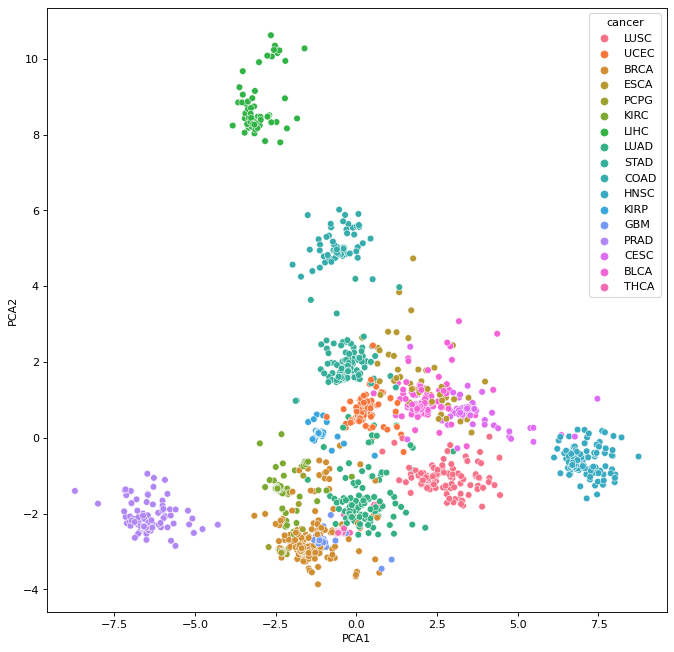

In [94]:
plt.figure(figsize=(10, 10), dpi=80)
sns.scatterplot(data=dff, x='PCA1', y='PCA2', hue='cancer')
plt.show()

In [95]:
from sklearn.manifold import TSNE

In [109]:
X_embedded = TSNE(n_components=2, perplexity=6).fit_transform(hid_tmr.detach().cpu().numpy())

In [110]:
dff2 = pd.DataFrame(X_embedded)
dff2.columns = ['TSNE1', 'TSNE2']
dff2['cancer'] = d.loc[test_set['tmr']]['type'].values
dff2

,TSNE1,TSNE2,cancer
0,83.638947,-1.964102,LUSC
1,-48.017326,-4.374278,UCEC
2,6.537364,-25.855972,BRCA
3,53.894550,-33.845295,ESCA
4,-38.743927,44.742367,PCPG
...,...,...,...
1574,25.517736,-61.693905,LIHC
1575,8.225556,5.354424,BLCA
1576,27.670509,-19.186714,STAD
1577,-20.959116,21.843081,KIRC


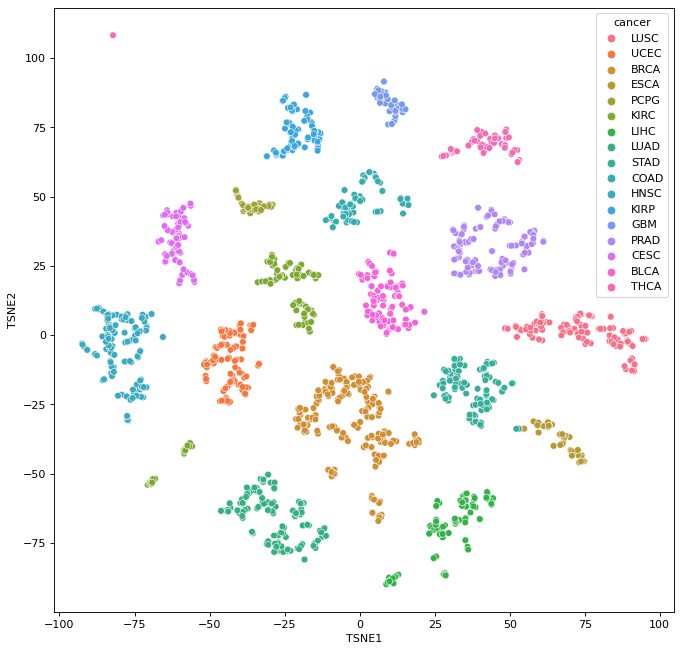

In [111]:
plt.figure(figsize=(10, 10), dpi=80)
sns.scatterplot(data=dff2, x='TSNE1', y='TSNE2', hue='cancer')
plt.show()

In [117]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients

In [133]:
from tqdm.notebook import tqdm

In [118]:
model.analysis()

,type,index
TCGA-A2-A0YF,BRCA,1
TCGA-E9-A22H,BRCA,1
TCGA-OL-A66L,BRCA,1
TCGA-BH-A0AY,BRCA,1
TCGA-AC-A3W5,BRCA,1
...,...,...
TCGA-A2-A0YE,BRCA,1
TCGA-E2-A9RU,BRCA,1
TCGA-BH-A0BT,BRCA,1
TCGA-D8-A1JJ,BRCA,1


In [181]:
G = [i.split('_')[1] for i in data.sga_sga.loc[d[d['type']=='BRCA'].index].sum(0).sort_values(ascending=False)[:5].index]
G

['PIK3CA', 'TP53', 'TRAPPC9', 'ERLIN2', 'GPR124']

In [182]:
lc = LayerConductance(model, model.layer_w_2)
scores = []
for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
    a = lc.attribute((X[idx], torch.from_numpy(test_set['can'][idx])), n_steps=7, attribute_to_layer_input=True, target=[ix]*len(X[idx]))
    ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    scores.append(ig_attr_test_norm_sum)

  0%|          | 0/2 [00:00<?, ?it/s]

In [183]:
g = np.array(data.gene_tf_sga.columns)
at = np.sum(scores, 0)

assert g.shape == at.shape

df = pd.DataFrame([g, at]).T
df.columns = ['label', 'score']
df.sort_values(by='score', ascending=False)[:10]

,label,score
130,FOXO3,0.524849
157,DNMT1,0.257812
187,NFATC3,0.22245
234,MYBL2,0.216019
235,ZEB1,0.036249
201,JUND,0.017613
42,SMARCC2,0.017242
22,TCF7L2,0.015034
59,NR2F6,0.008634
116,RUNX3,0.00667


In [189]:
lc = LayerConductance(model, model.genes)
scores = []
for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
    a = lc.attribute((X[idx], torch.from_numpy(test_set['can'][idx])), n_steps=7, attribute_to_layer_input=False, target=[ix]*len(X[idx]))
    ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    scores.append(ig_attr_test_norm_sum)

  0%|          | 0/2 [00:00<?, ?it/s]

In [190]:
a.shape

torch.Size([196, 320])

In [191]:
[m.shape for m in masks]

[(320, 1387), (1387, 1066), (1066, 447), (447, 147), (147, 26), (26, 1)]

In [192]:
g = np.array(masks[0].index)
at = np.sum(scores, 0)

assert g.shape == at.shape

df = pd.DataFrame([g, at]).T
df.columns = ['label', 'score']
df.sort_values(by='score', ascending=False)[:10]

,label,score
130,FOXO3,0.524849
157,DNMT1,0.257812
187,NFATC3,0.22245
234,MYBL2,0.216019
235,ZEB1,0.036249
201,JUND,0.017613
42,SMARCC2,0.017242
22,TCF7L2,0.015034
59,NR2F6,0.008634
116,RUNX3,0.00667


In [193]:
import torch

In [194]:
loss = torch.nn.CrossEntropyLoss()